In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
import scipy
import matplotlib.patches as mpatches
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
import statsmodels.stats.multitest as multitest

import statsmodels.api as sm


In [2]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

def load_time_series(subject, session, unit_id):
    #subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    subj_mat = hdf5storage.loadmat(f"/Volumes/Nexus/DBS/{subject}/Preprocessed Data/SpikeSorting/{subject}_ft_raw_spike.mat")
    time_data = subj_mat['IFR'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['IFR'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-2][time_point>time_data.min()+2]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)

# function to convert to superscript
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

In [3]:
#group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")
#group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/MGH BML/Sound-induced_STN_activity/manuscript/group_data_narrow_09082021.mat")
group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/stn_auditory/group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

,SubjectID,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,1,micro_m,6,4,MU,B
1,DBS3001,2,micro_c,7,1,MU,C


(229, 7)

In [4]:
def get_subj_table(produced_freq, number_elec, info, timing_subj, neural_subj):
    SUBJ = info.iloc[number_elec, 0]
    SESS = info.iloc[number_elec, 1]
    subj_table = produced_freq[produced_freq.subject == SUBJ].reset_index(drop=1)
    subj_table = subj_table[subj_table.session_id == SESS].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts > timing_subj.min()+3.5].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts < timing_subj.max()-3.5].reset_index(drop=1)

        
    subj_table['avg_spike'] = np.nan
    for trial in range(subj_table.shape[0]):
        if subj_table.ends[trial] < timing_subj.max() - 3.5:
            if subj_table.starts[trial] > timing_subj.min() + 3.5:
                subj_table.avg_spike[trial] = get_avg_spike(subj_table.iloc[trial], 
                                                            neural_subj, timing_subj)
    subj_table = subj_table.dropna().reset_index(drop=1)
    
    subj_table['t_z'] = (subj_table['t'] - subj_table['t'].mean())/subj_table['t'].std(ddof=0)
    stim_vol_mean = subj_table['stim_volume'].mean()
    subj_table['stim_vol_z'] = (subj_table['stim_volume'] - 
                                   stim_vol_mean)/subj_table['stim_volume'].std(ddof=0)
    if subj_table['stim_volume'].unique().shape[0]==1:
        subj_table['stim_vol_z'] = 0
        

    subj_table['syl_id_z'] = (subj_table['syl_id'] - 
                              subj_table['syl_id'].mean())/subj_table['syl_id'].std(ddof=0)
    subj_table['spl_z'] = (subj_table['spl'] - 
                           subj_table['spl'].mean())/subj_table['spl'].std(ddof=0)
    stim_fac_mean = subj_table['stim_factor'].mean()
    subj_table['stim_z'] = (subj_table['stim_factor'] - 
                                   stim_fac_mean)/subj_table['stim_factor'].std(ddof=0)
    fund_freq_mean = subj_table['fundamental_freq'].mean()
    subj_table['pitch_z'] = (subj_table['fundamental_freq'] - 
                             fund_freq_mean)/subj_table['fundamental_freq'].std(ddof=0)
    subj_table['pitch_spl_z'] = subj_table['pitch_z']*subj_table['spl_z']

    return subj_table

In [5]:
def get_produced_freq():
    produced_freq = pd.read_csv('all_freq.csv', index_col='id')
    d = {'ah':0, 'oo':1, 'ee':2}
    produced_freq['stim_factor'] = produced_freq.stim.map(d)
    produced_freq['spl'] = 20*np.log10(produced_freq['rms_audio_p'])
    produced_freq = produced_freq.dropna().reset_index(drop=1)

    produced_freq['before_time'] = np.nan
    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 2:
            if produced_freq.syl_id[item-1] == 1:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]
        elif produced_freq.syl_id[item] == 3:
            if produced_freq.syl_id[item-1] == 2:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]

    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 1:
            if produced_freq.syl_id[item+1] == 2:
                if produced_freq.syl_id[item+2] == 3:
                    produced_freq.before_time[item] = (produced_freq.before_time[item+1] + 
                                                       produced_freq.before_time[item+2])/2

    produced_freq.before_time[0] = (produced_freq.before_time[1] + produced_freq.before_time[2])/2
    produced_freq = produced_freq.dropna().reset_index(drop=1)
    return produced_freq

produced_df = get_produced_freq()
produced_df.shape
produced_df.head(2)

(41210, 26)

,starts,ends,duration,cons_onset,trial_id,session_id,syl_id,channel,fundamental_freq,type,...,subject,freq2,discont,contrun_id,t,t2,t3,stim_factor,spl,before_time
0,36145.009713,36145.184457,0.174745,36145.009713,1,1,1,audio_p,142.196732,vowel,...,DBS3001,20219.910530,1,1,-195.420094,38189.013071,-7.462901e+06,0,-18.178208,0.404081
1,36145.494905,36145.643055,0.148150,36145.494905,1,1,2,audio_p,140.861581,vowel,...,DBS3001,19841.984898,0,1,-194.934901,37999.615755,-7.407451e+06,1,-21.894791,0.310448


In [6]:
def get_avg_spike(time_table, neural_data, time_data, fs=1000):
    time_point = time_table['starts']
    before = time_table['before_time']
    after = time_table['duration']
    dfs = []

    for item in range(len(neural_data)):
        if time_data[item] > time_point:
            dfs.append(neural_data[item-int(before*fs):item+int(after*fs)])
            break
    return np.mean(np.array(dfs))

In [7]:
def get_subj_df_cue(subject, sess, subj_table):
    #cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{subject}/Preprocessed Data/Sync/annot/{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df[cue_df['session_id']==sess].reset_index(drop=1)
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    return subj_table_cue

def find_rest_time(subject_df):
    resting_time = subject_df[subject_df['syl_id'] == 1]['starts_y'] - 1
    return resting_time

In [8]:

def find_full_3_trial(subj_table, timing_subj):
    good_trial = []
    subj_table = subj_table.dropna()
    subj_table = subj_table[subj_table['starts_y'] > timing_subj.min() + 3.5]
    subj_table = subj_table[subj_table['ends_x'] < timing_subj.max() - 3.5]
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0] == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [9]:
def get_produced_phoneme(subject):
    #produced_phoneme = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_produced_phoneme.txt', sep='	', index_col='id')
    produced_phoneme = pd.read_csv(f'/Volumes/Nexus/DBS/{subject}/Preprocessed Data/Sync/annot/{subject}_produced_phoneme.txt', sep='	', index_col='id')
    return produced_phoneme

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])

In [10]:
def load_spikes(subject, session, unit_id):
    #subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    subj_mat = hdf5storage.loadmat(f"/Volumes/Nexus/DBS/{subject}/Preprocessed Data/SpikeSorting/{subject}_ft_raw_spike.mat")
    time_data = subj_mat['SpikeBin'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['SpikeBin'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

In [11]:
xvals = np.linspace(-1, 3.5, 4500)
spike_value = 1

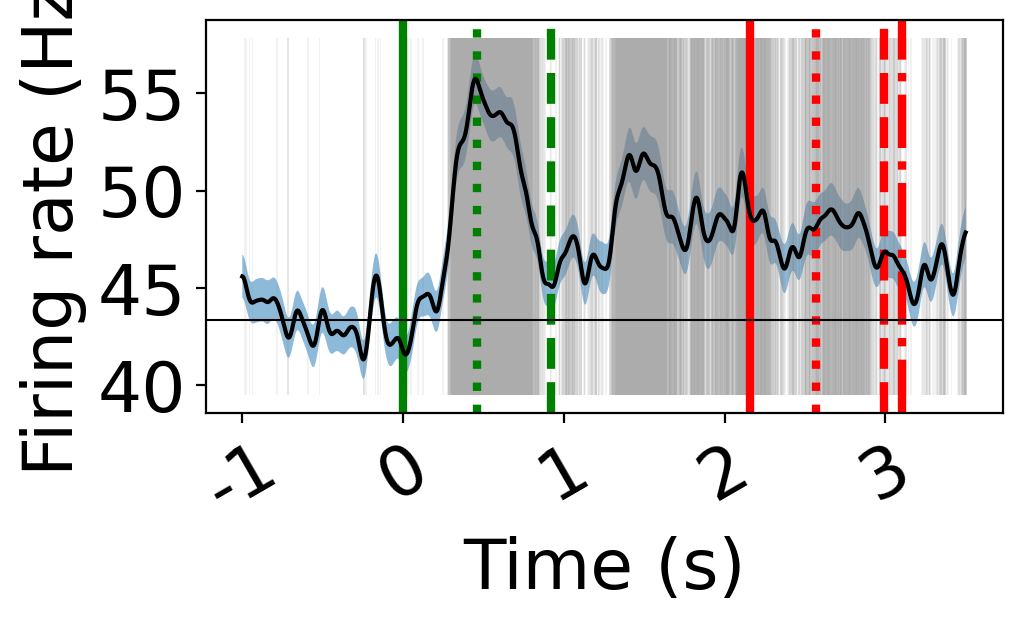

In [12]:
number_elec = 74

SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
subj_df_cue = find_full_3_trial(subj_df_cue, timing)

cue_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
cue_start_2 = subj_df_cue[subj_df_cue['syl_id'] == 2]['starts_y']
cue_start_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['starts_y']

produced_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_x']
produced_start_2 = subj_df_cue[subj_df_cue['syl_id'] == 2]['starts_x']
produced_start_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['starts_x']
produced_end_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['ends_x']

relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
spike_mat = get_df(relative_time, neural_df, timing, after=3.5, before=1)
mean = np.nanmean(spike_mat, axis=0)
sem = nansem(spike_mat, axis=0)

rest_time = find_rest_time(subj_df_cue)
rest_spike = get_df(rest_time, neural_df, timing, before=0, after=0.75)
FR_mean = rest_spike.mean()
FR_std = np.nanstd(rest_spike)
FR_compare = FR_std * np.random.randn(100, 4500) + FR_mean


fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=200, constrained_layout=1)
axs.patch.set_alpha(0)

axs.axvline(cue_start_1.mean() - relative_time.mean(), 
                                      color='g', linewidth=3)
axs.axvline(cue_start_2.mean() - relative_time.mean(), 
                                      color='g', linewidth=3, linestyle='dotted')
axs.axvline(cue_start_3.mean() - relative_time.mean(), 
                                      color='g', linewidth=3, linestyle='dashed')

axs.axvline(produced_start_1.mean() - relative_time.mean(), 
                                      color='r', linewidth=3)
axs.axvline(produced_start_2.mean() - relative_time.mean(), 
                                      color='r', linewidth=3, linestyle='dotted')
axs.axvline(produced_start_3.mean() - relative_time.mean(), 
                                      color='r', linewidth=3, linestyle='dashed')
axs.axvline(produced_end_3.mean() - relative_time.mean(), 
                                      color='r', linewidth=3, linestyle='dashdot')
axs.axhline(FR_mean, color='k', linewidth=0.75)


axs.plot(xvals, mean, 'k')

axs.fill_between(xvals, mean-sem, mean+sem, alpha=0.5)

significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(spike_mat, FR_compare).pvalue})
patch_y = axs.get_ylim()[1] - axs.get_ylim()[0]
for item in range(len(xvals)):
    if multitest.fdrcorrection(significance.pval)[0][item] == True:
        axs.add_patch(mpatches.Rectangle((item/1000-1, 
                                                   axs.get_ylim()[0]), 
                                                  0.01, patch_y, color='grey', 
                                                  alpha=0.1, ec=None))



axs.set_xticklabels(axs.get_xticks().astype(int), fontsize=25, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
axs.set_xlabel('Time (s)', fontsize=25)
axs.set_ylabel('Firing rate (Hz)', fontsize=25)
plt.plot();

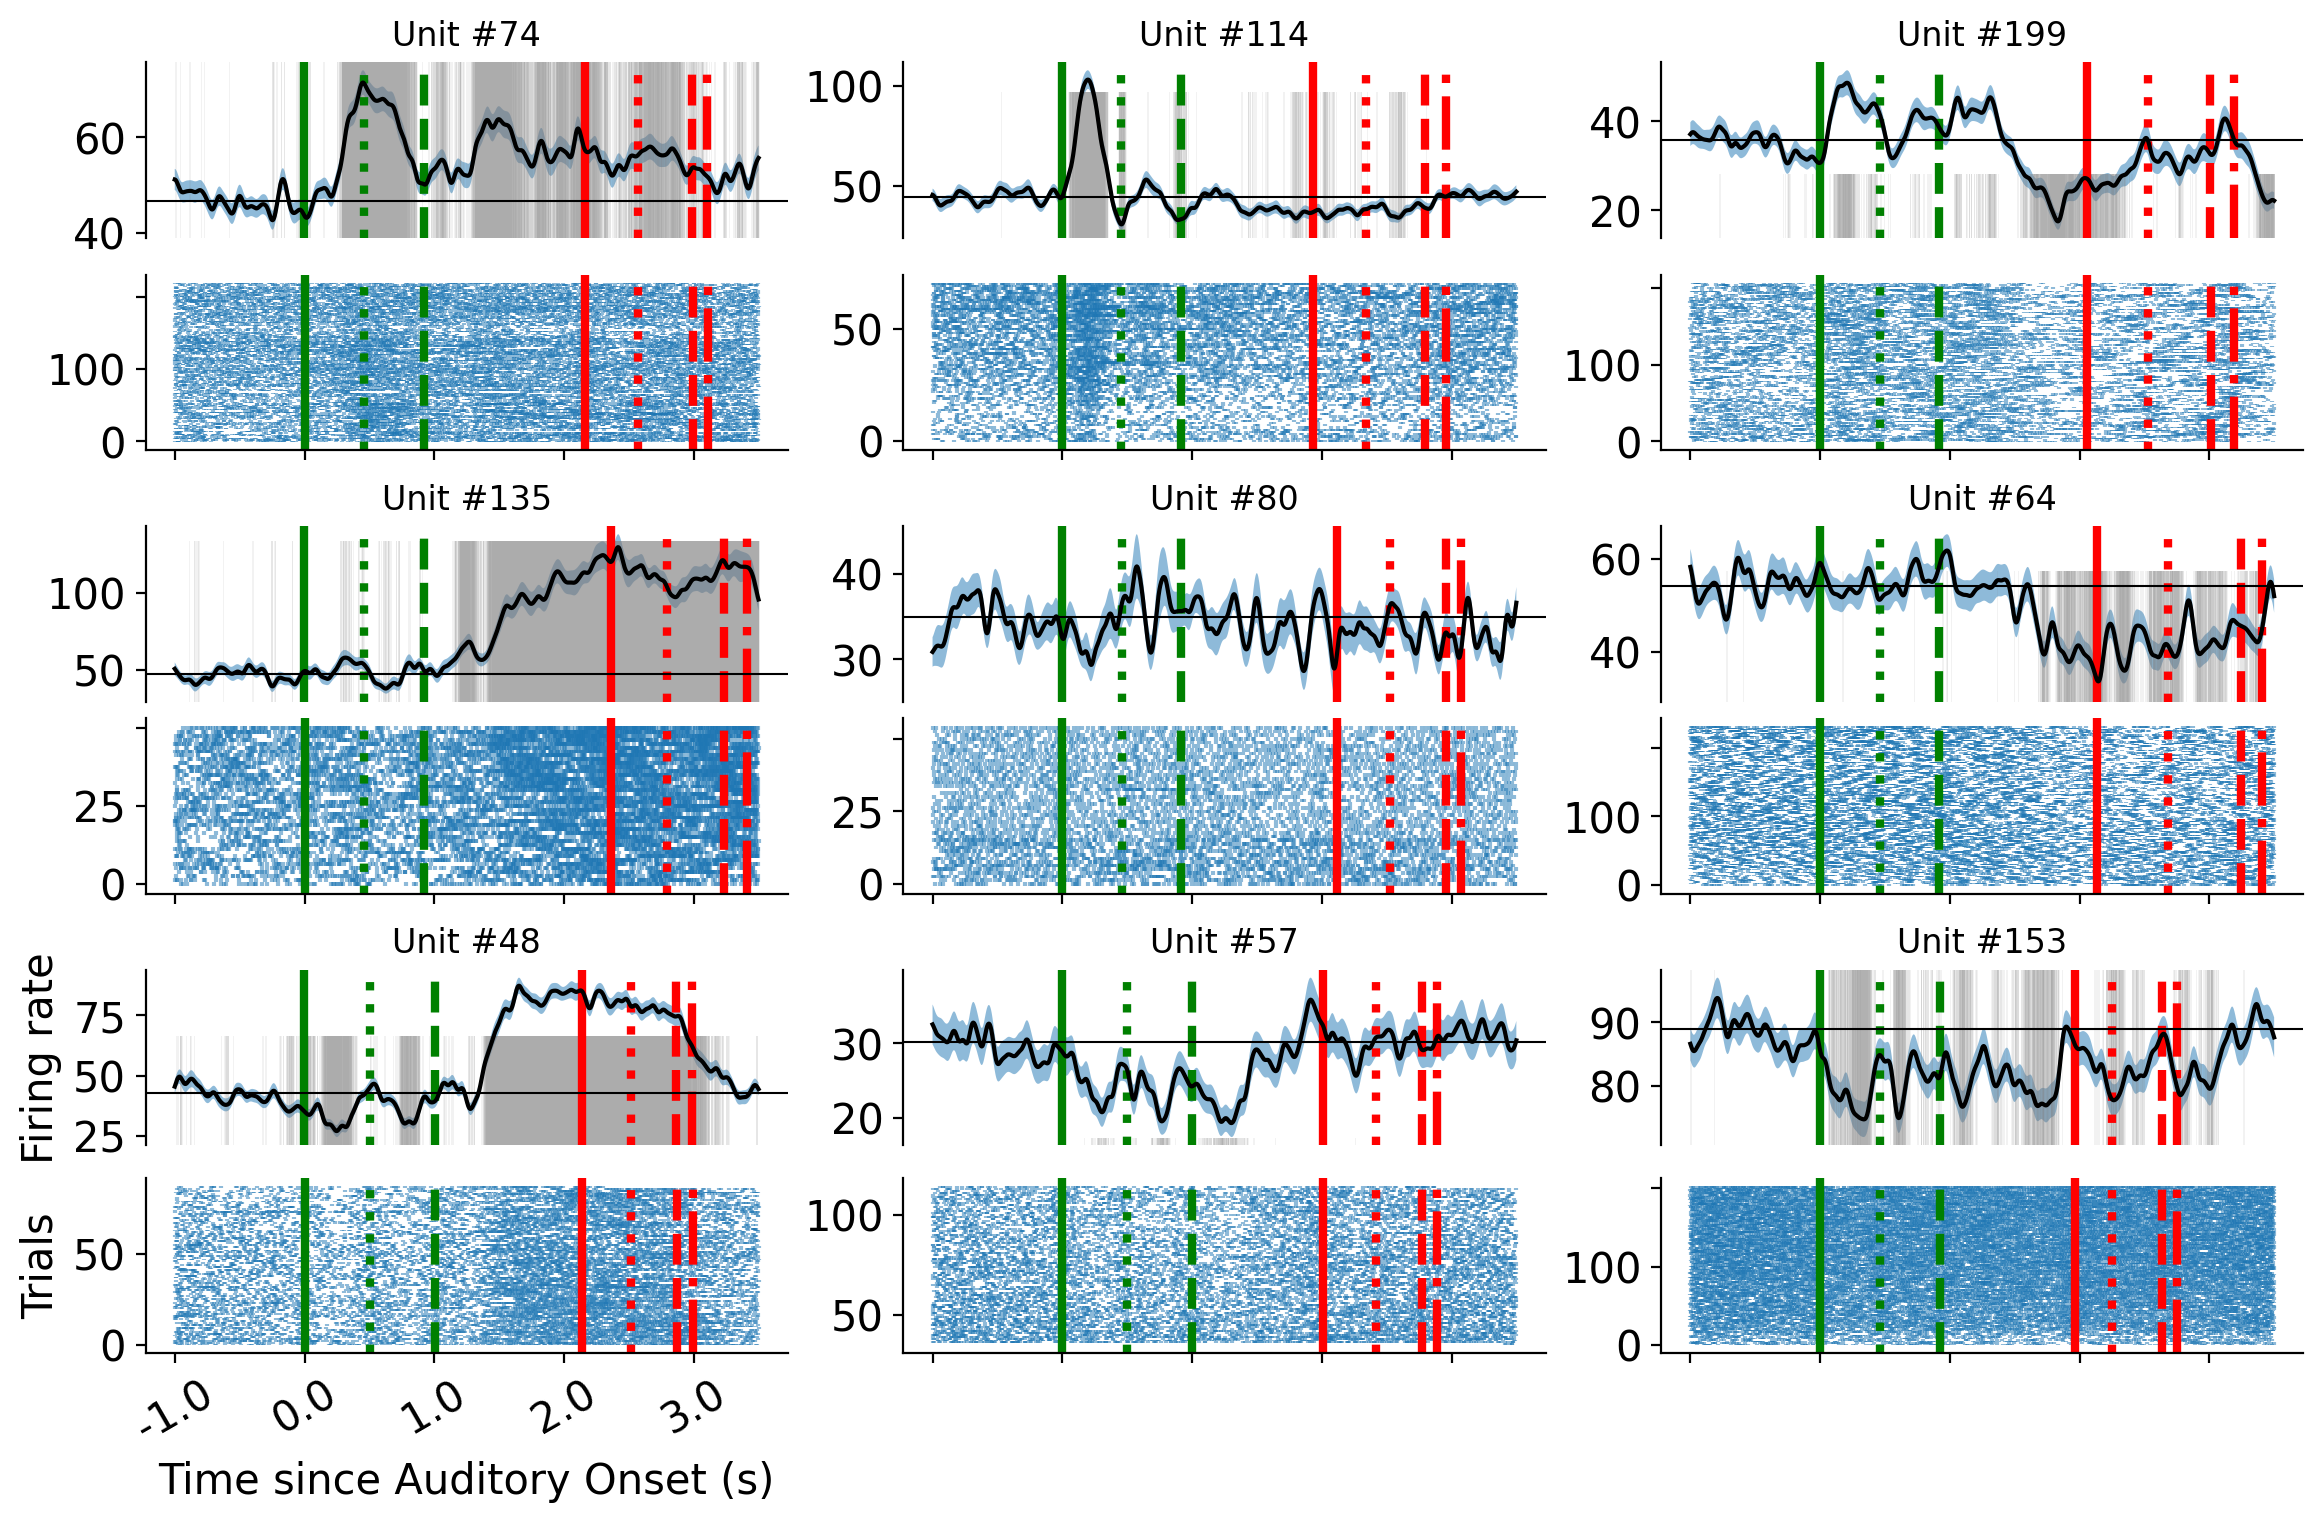

In [13]:

fig, axs = plt.subplots(6, 3, figsize=(11.5, 7.5), dpi=200, constrained_layout=1)

axs = axs.flatten()
for item in range(len(axs)):
    axs[item].patch.set_alpha(0)
fig.patch.set_alpha(0)

elec_list = [74, 114, 199, 135, 80, 64, 48, 57, 153]
loc_list = [0, 1, 2, 6, 7, 8, 12, 13, 14]

for item, number_elec in enumerate(elec_list):

    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]
    
    timing, neural_df = load_time_series(SUBJECT, session, contact)
    
    subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
    subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
    subj_df_cue = find_full_3_trial(subj_df_cue, timing)
    
    cue_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
    cue_start_2 = subj_df_cue[subj_df_cue['syl_id'] == 2]['starts_y']
    cue_start_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['starts_y']
    
    produced_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_x']
    produced_start_2 = subj_df_cue[subj_df_cue['syl_id'] == 2]['starts_x']
    produced_start_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['starts_x']
    produced_end_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['ends_x']
    
    relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
    spike_mat = get_df(relative_time, neural_df, timing, after=3.5, before=1)
    mean = np.nanmean(spike_mat, axis=0)
    sem = nansem(spike_mat, axis=0)
    
    rest_time = find_rest_time(subj_df_cue)
    rest_spike = get_df(rest_time, neural_df, timing, before=0, after=0.75)
    FR_mean = rest_spike.mean()
    FR_std = np.nanstd(rest_spike)
    FR_compare = FR_std * np.random.randn(100, 4500) + FR_mean
    
    axs_loc = loc_list[item]
    
    axs[axs_loc].patch.set_alpha(0)
    
    axs[axs_loc].axvline(cue_start_1.mean() - relative_time.mean(), 
                                          color='g', linewidth=3)
    axs[axs_loc].axvline(cue_start_2.mean() - relative_time.mean(), 
                                          color='g', linewidth=3, linestyle='dotted')
    axs[axs_loc].axvline(cue_start_3.mean() - relative_time.mean(), 
                                          color='g', linewidth=3, linestyle='dashed')
    
    axs[axs_loc].axvline(produced_start_1.mean() - relative_time.mean(), 
                                          color='r', linewidth=3)
    axs[axs_loc].axvline(produced_start_2.mean() - relative_time.mean(), 
                                          color='r', linewidth=3, linestyle='dotted')
    axs[axs_loc].axvline(produced_start_3.mean() - relative_time.mean(), 
                                          color='r', linewidth=3, linestyle='dashed')
    axs[axs_loc].axvline(produced_end_3.mean() - relative_time.mean(), 
                                          color='r', linewidth=3, linestyle='dashdot')
    axs[axs_loc].axhline(FR_mean, color='k', linewidth=0.75)
    
    
    axs[axs_loc].plot(xvals, mean, 'k')
    
    axs[axs_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
    
    significance = pd.DataFrame({"xvals":xvals, 
                                 "pval":f_oneway(spike_mat, FR_compare).pvalue})
    patch_y = axs[axs_loc].get_ylim()[1] - axs[0].get_ylim()[0]
    for item in range(len(xvals)):
        if multitest.fdrcorrection(significance.pval)[0][item] == True:
            axs[axs_loc].add_patch(mpatches.Rectangle((item/1000-1, 
                                                       axs[axs_loc].get_ylim()[0]), 
                                                      0.01, patch_y, color='grey', 
                                                      alpha=0.1, ec=None))
    
    axs[axs_loc].tick_params(labelleft=1, labeltop=0, labelright=0, labelbottom=0, bottom=0)
    axs[axs_loc].set_yticklabels(axs[axs_loc].get_yticks().astype(int), fontsize=15)
    sns.despine(ax=axs[axs_loc], top=True, right=True, left=False, bottom=True)
    axs[axs_loc].set_title(f'Unit #{number_elec}')
    
    timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
    spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1)
    
    axs[axs_loc+3].patch.set_alpha(0)
    for trial in range(len(spikes)):
        spike_times = [i for i, x in enumerate(spikes[trial]) if x == spike_value]
        axs[axs_loc+3].vlines(spike_times, trial - 0.5, trial + 0.5, alpha=0.5)
        
    axs[axs_loc+3].axvline((cue_start_1.mean() - relative_time.mean() + 1)*1000, 
                         color='g', linewidth=3)
    axs[axs_loc+3].axvline((cue_start_2.mean() - relative_time.mean() + 1)*1000, 
                         color='g', linewidth=3, linestyle='dotted')
    axs[axs_loc+3].axvline((cue_start_3.mean() - relative_time.mean() + 1)*1000, 
                         color='g', linewidth=3, linestyle='dashed')
    
    axs[axs_loc+3].axvline((produced_start_1.mean() - relative_time.mean() + 1)*1000, 
                         color='r', linewidth=3)
    axs[axs_loc+3].axvline((produced_start_2.mean() - relative_time.mean() + 1)*1000, 
                         color='r', linewidth=3, linestyle='dotted')
    axs[axs_loc+3].axvline((produced_start_3.mean() - relative_time.mean() + 1)*1000, 
                         color='r', linewidth=3, linestyle='dashed')
    axs[axs_loc+3].axvline((produced_end_3.mean() - relative_time.mean() + 1)*1000, 
                         color='r', linewidth=3, linestyle='dashdot')
    axs[axs_loc+3].set_yticklabels(axs[axs_loc+3].get_yticks().astype(int)[:-1], fontsize=15)
    sns.despine(ax=axs[axs_loc+3], top=True, right=True, left=False, bottom=False)
    axs[axs_loc+3].set_xticklabels([])



axs[15].set_xticks(np.linspace(0, 4000, 5))
axs[15].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15, rotation=30)
axs[15].set_xlabel('Time since Auditory Onset (s)', fontsize=15)
axs[15].set_ylabel('Trials', fontsize=15)
axs[12].set_ylabel('Firing rate', fontsize=15)

plt.show();

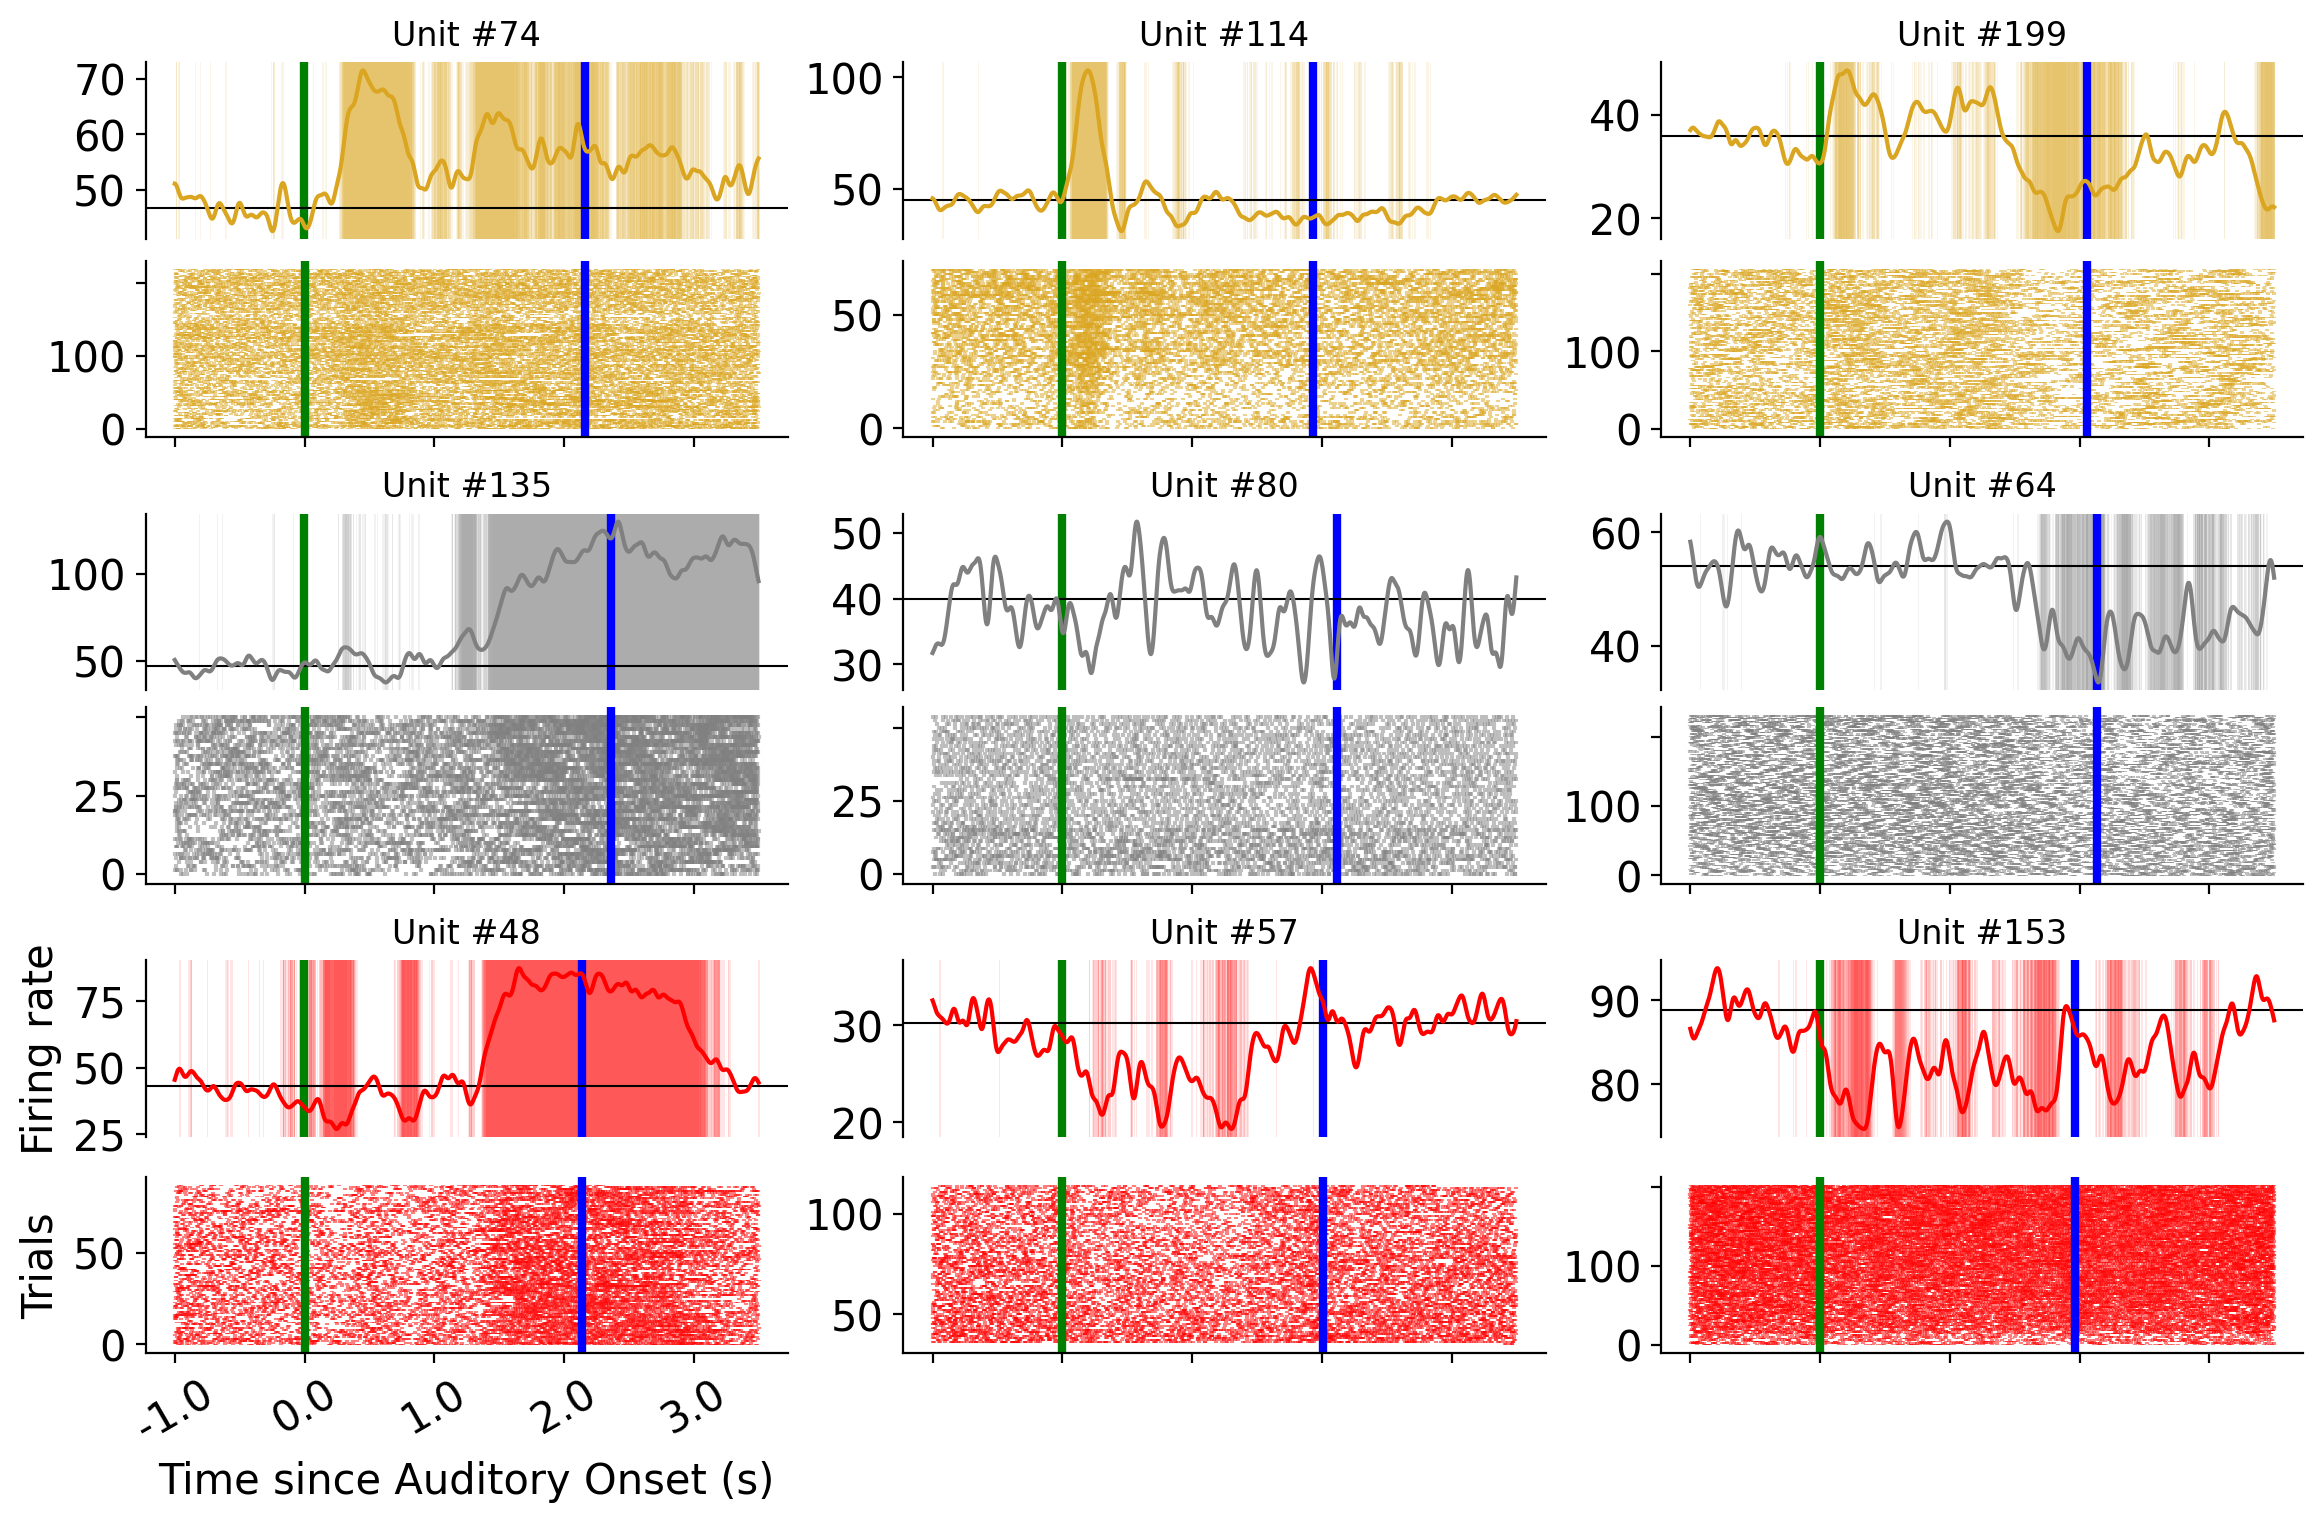

In [24]:

fig, axs = plt.subplots(6, 3, figsize=(11.5, 7.5), dpi=200, constrained_layout=1)

axs = axs.flatten()
for item in range(len(axs)):
    axs[item].patch.set_alpha(0)
fig.patch.set_alpha(0)

elec_list = [74, 114, 199, 135, 80, 64, 48, 57, 153]
loc_list = [0, 1, 2, 6, 7, 8, 12, 13, 14]
color_list = ['goldenrod', 'goldenrod', 'goldenrod', 
              'grey', 'grey', 'grey', 
              'red', 'red', 'red']

for item, number_elec in enumerate(elec_list):

    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]
    
    timing, neural_df = load_time_series(SUBJECT, session, contact)
    
    subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
    subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
    subj_df_cue = find_full_3_trial(subj_df_cue, timing)
    
    cue_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
    cue_start_2 = subj_df_cue[subj_df_cue['syl_id'] == 2]['starts_y']
    cue_start_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['starts_y']
    
    produced_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_x']
    produced_start_2 = subj_df_cue[subj_df_cue['syl_id'] == 2]['starts_x']
    produced_start_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['starts_x']
    produced_end_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['ends_x']
    
    relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
    spike_mat = get_df(relative_time, neural_df, timing, after=3.5, before=1)
    mean = np.nanmean(spike_mat, axis=0)
    sem = nansem(spike_mat, axis=0)
    
    rest_time = find_rest_time(subj_df_cue)
    rest_spike = get_df(rest_time, neural_df, timing, before=0, after=0.75)
    FR_mean = rest_spike.mean()
    FR_std = np.nanstd(rest_spike)
    FR_compare = FR_std * np.random.randn(100, 4500) + FR_mean
    
    axs_loc = loc_list[item]
    
    axs[axs_loc].patch.set_alpha(0)
    
    axs[axs_loc].axvline(cue_start_1.mean() - relative_time.mean(), 
                                          color='g', linewidth=3)

    
    axs[axs_loc].axvline(produced_start_1.mean() - relative_time.mean(), 
                                          color='b', linewidth=3)

    axs[axs_loc].axhline(FR_mean, color='k', linewidth=0.75)
    
    
    axs[axs_loc].plot(xvals, mean, color_list[item])
        
    significance = pd.DataFrame({"xvals":xvals, 
                                 "pval":f_oneway(spike_mat, FR_compare).pvalue})
    patch_y = axs[axs_loc].get_ylim()[1] - axs[axs_loc].get_ylim()[0]
    for i2 in range(len(xvals)):
        if multitest.fdrcorrection(significance.pval)[0][i2] == True:
            axs[axs_loc].add_patch(mpatches.Rectangle((i2/1000-1, 
                                                       axs[axs_loc].get_ylim()[0]), 
                                                      0.01, patch_y, fc=color_list[item], 
                                                      alpha=0.1, ec=None))
    
    axs[axs_loc].tick_params(labelleft=1, labeltop=0, labelright=0, labelbottom=0, bottom=0)
    axs[axs_loc].set_yticklabels(axs[axs_loc].get_yticks().astype(int), fontsize=15)
    sns.despine(ax=axs[axs_loc], top=True, right=True, left=False, bottom=True)
    axs[axs_loc].set_title(f'Unit #{number_elec}')
    
    timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
    spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1)
    
    axs[axs_loc+3].patch.set_alpha(0)
    for trial in range(len(spikes)):
        spike_times = [i for i, x in enumerate(spikes[trial]) if x == spike_value]
        axs[axs_loc+3].vlines(spike_times, trial - 0.5, trial + 0.5, alpha=0.5, color=color_list[item])
        
    axs[axs_loc+3].axvline((cue_start_1.mean() - relative_time.mean() + 1)*1000, 
                         color='g', linewidth=3)

    
    axs[axs_loc+3].axvline((produced_start_1.mean() - relative_time.mean() + 1)*1000, 
                         color='b', linewidth=3)

    axs[axs_loc+3].set_yticklabels(axs[axs_loc+3].get_yticks().astype(int)[:-1], fontsize=15)
    sns.despine(ax=axs[axs_loc+3], top=True, right=True, left=False, bottom=False)
    axs[axs_loc+3].set_xticklabels([])



axs[15].set_xticks(np.linspace(0, 4000, 5))
axs[15].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15, rotation=30)
axs[15].set_xlabel('Time since Auditory Onset (s)', fontsize=15)
axs[15].set_ylabel('Trials', fontsize=15)
axs[12].set_ylabel('Firing rate', fontsize=15)

plt.show();

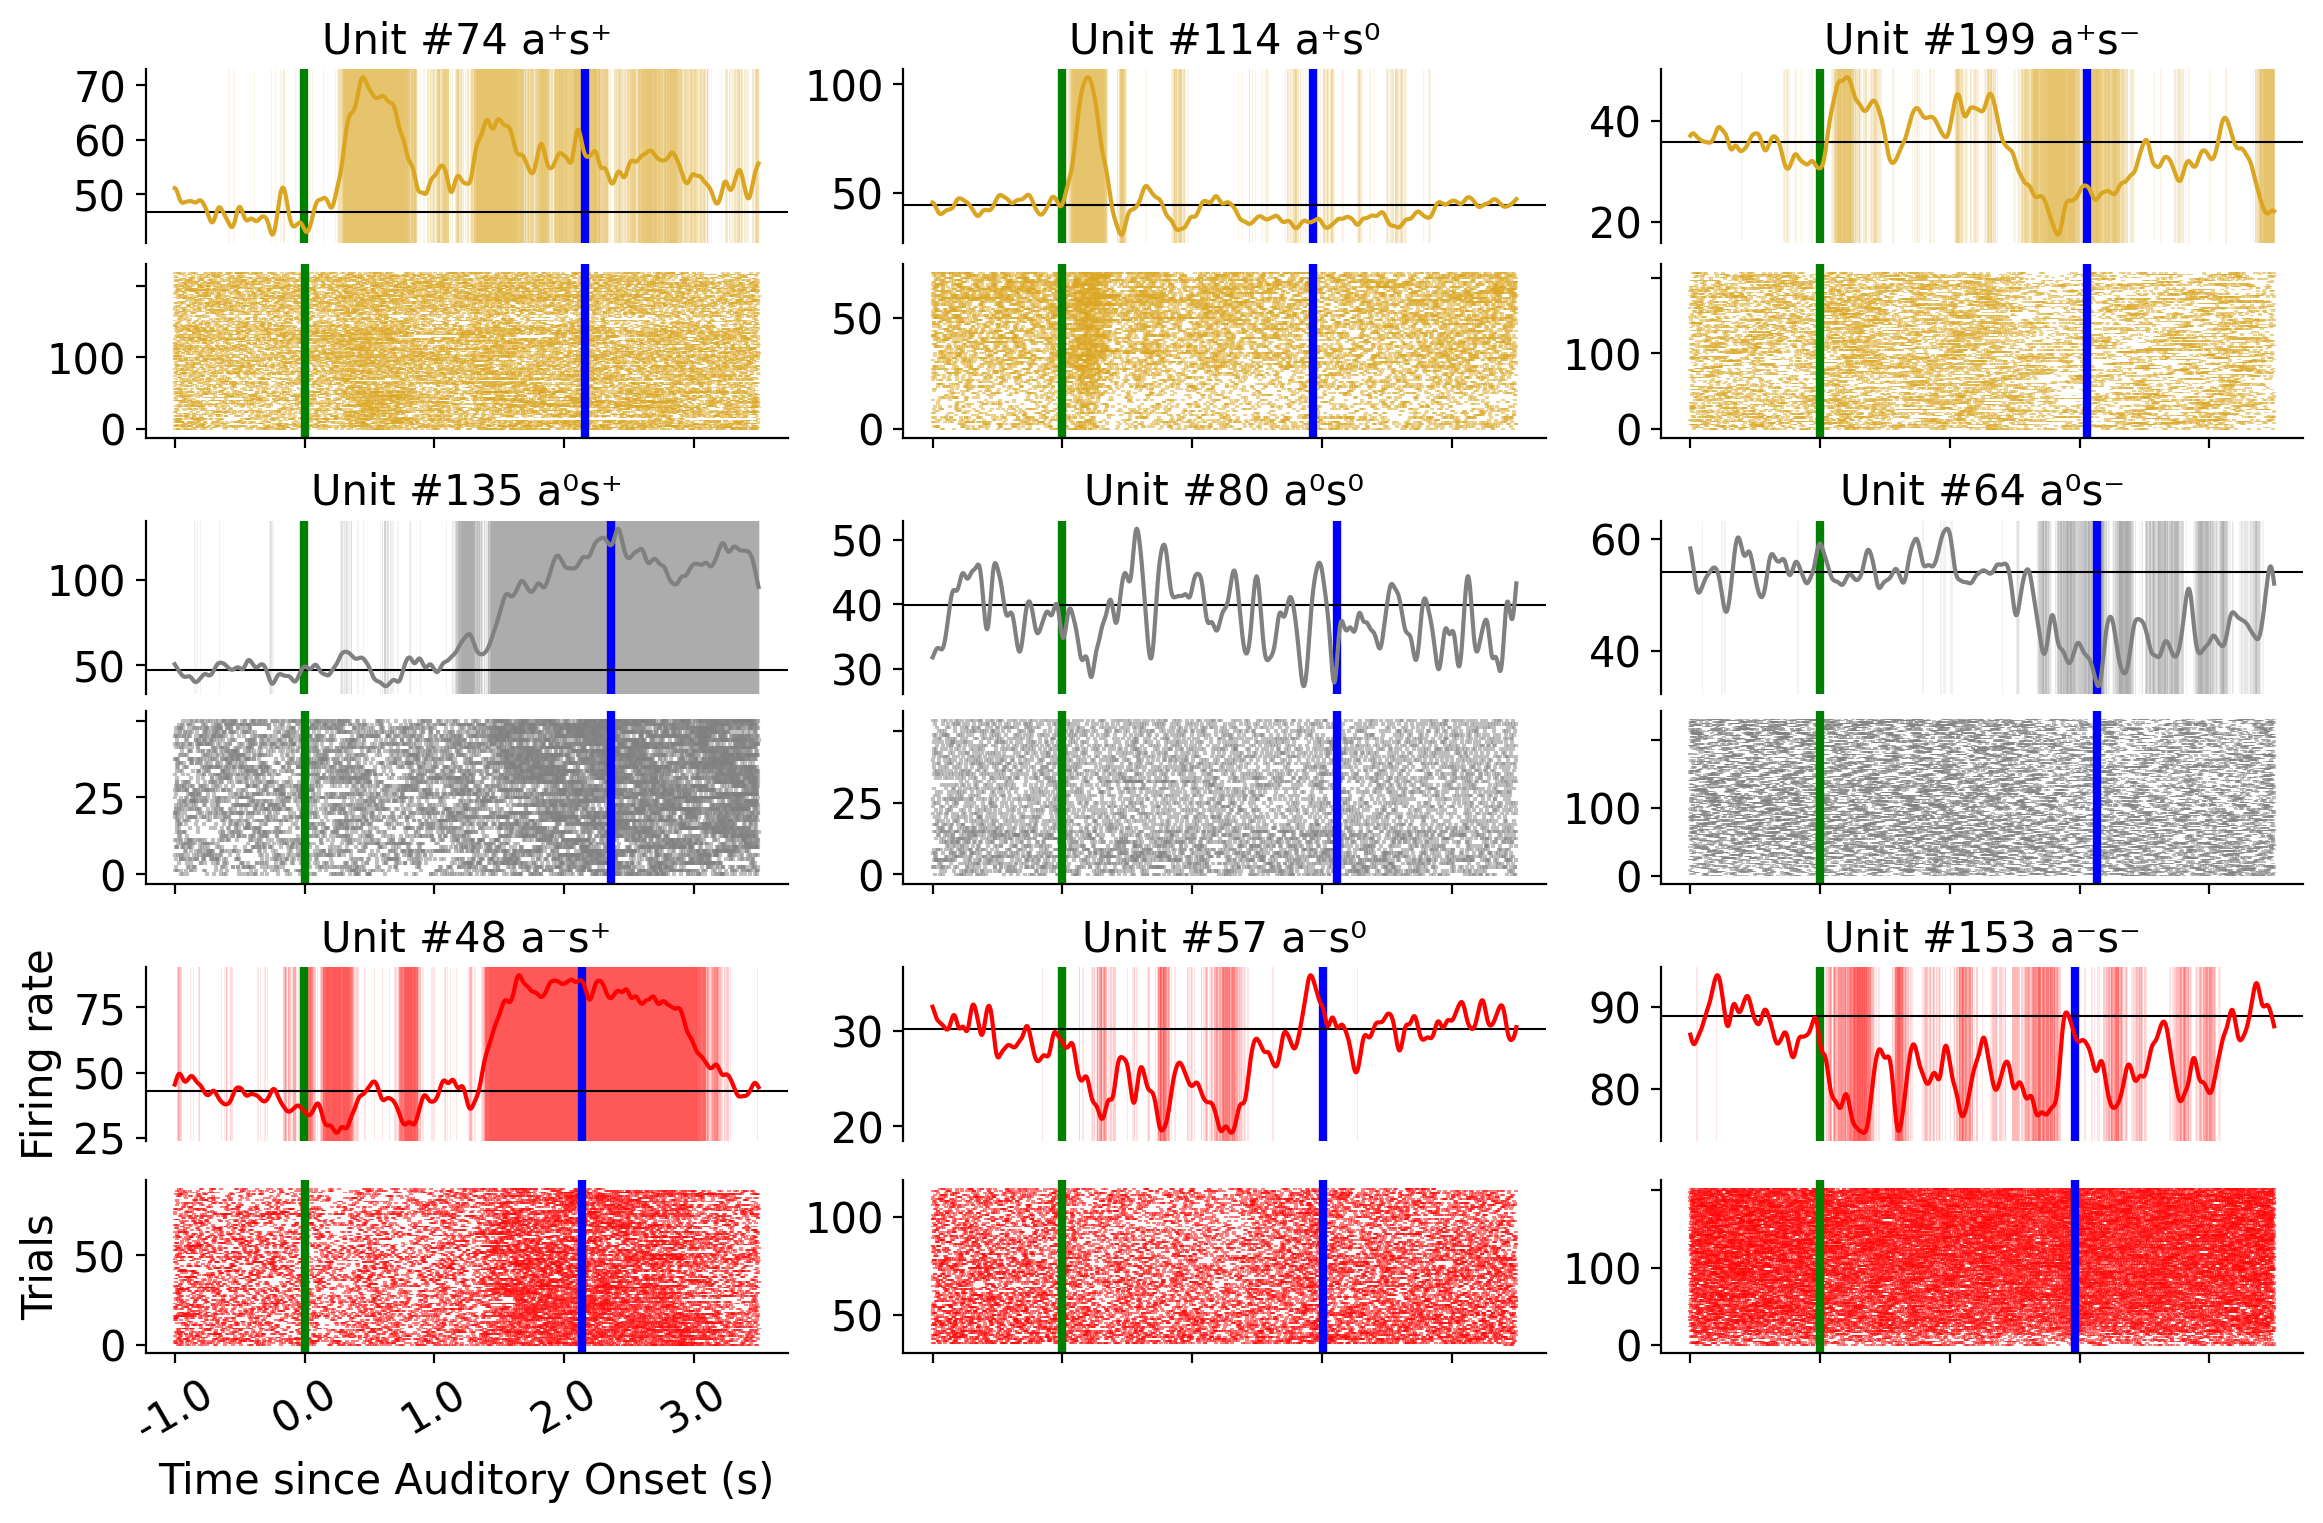

In [68]:

fig, axs = plt.subplots(6, 3, figsize=(11.5, 7.5), dpi=200, constrained_layout=1)

axs = axs.flatten()
for item in range(len(axs)):
    axs[item].patch.set_alpha(0)
fig.patch.set_alpha(0)

elec_list = [74, 114, 199, 135, 80, 64, 48, 57, 153]
loc_list = [0, 1, 2, 6, 7, 8, 12, 13, 14]
color_list = ['goldenrod', 'goldenrod', 'goldenrod', 
              'grey', 'grey', 'grey', 
              'red', 'red', 'red']

for item, number_elec in enumerate(elec_list):

    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]
    
    timing, neural_df = load_time_series(SUBJECT, session, contact)
    
    subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
    subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
    subj_df_cue = find_full_3_trial(subj_df_cue, timing)
    
    cue_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
    cue_start_2 = subj_df_cue[subj_df_cue['syl_id'] == 2]['starts_y']
    cue_start_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['starts_y']
    
    produced_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_x']
    produced_start_2 = subj_df_cue[subj_df_cue['syl_id'] == 2]['starts_x']
    produced_start_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['starts_x']
    produced_end_3 = subj_df_cue[subj_df_cue['syl_id'] == 3]['ends_x']
    
    relative_time = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
    spike_mat = get_df(relative_time, neural_df, timing, after=3.5, before=1)
    mean = np.nanmean(spike_mat, axis=0)
    sem = nansem(spike_mat, axis=0)
    
    rest_time = find_rest_time(subj_df_cue)
    rest_spike = get_df(rest_time, neural_df, timing, before=0, after=0.75)
    FR_mean = rest_spike.mean()
    FR_std = np.nanstd(rest_spike)
    FR_compare = FR_std * np.random.randn(100, 4500) + FR_mean
    
    axs_loc = loc_list[item]
    
    axs[axs_loc].patch.set_alpha(0)
    
    axs[axs_loc].axvline(cue_start_1.mean() - relative_time.mean(), 
                                          color='g', linewidth=3)

    
    axs[axs_loc].axvline(produced_start_1.mean() - relative_time.mean(), 
                                          color='b', linewidth=3)

    axs[axs_loc].axhline(FR_mean, color='k', linewidth=0.75)
    
    
    axs[axs_loc].plot(xvals, mean, color_list[item])
        
    significance = pd.DataFrame({"xvals":xvals, 
                                 "pval":f_oneway(spike_mat, FR_compare).pvalue})
    patch_y = axs[axs_loc].get_ylim()[1] - axs[axs_loc].get_ylim()[0]
    for i2 in range(len(xvals)):
        if multitest.fdrcorrection(significance.pval)[0][i2] == True:
            axs[axs_loc].add_patch(mpatches.Rectangle((i2/1000-1, 
                                                       axs[axs_loc].get_ylim()[0]), 
                                                      0.01, patch_y, fc=color_list[item], 
                                                      alpha=0.1, ec=None))
    
    axs[axs_loc].tick_params(labelleft=1, labeltop=0, labelright=0, labelbottom=0, bottom=0)
    axs[axs_loc].set_yticklabels(axs[axs_loc].get_yticks().astype(int), fontsize=15)
    sns.despine(ax=axs[axs_loc], top=True, right=True, left=False, bottom=True)
    axs[axs_loc].set_title(f'Unit #{number_elec}')
    
    timing_spike, spike_df = load_spikes(SUBJECT, session, contact)
    spikes = get_df(relative_time, spike_df, timing_spike, after=3.5, before=1)
    
    axs[axs_loc+3].patch.set_alpha(0)
    for trial in range(len(spikes)):
        spike_times = [i for i, x in enumerate(spikes[trial]) if x == spike_value]
        axs[axs_loc+3].vlines(spike_times, trial - 0.5, trial + 0.5, alpha=0.5, color=color_list[item])
        
    axs[axs_loc+3].axvline((cue_start_1.mean() - relative_time.mean() + 1)*1000, 
                         color='g', linewidth=3)

    
    axs[axs_loc+3].axvline((produced_start_1.mean() - relative_time.mean() + 1)*1000, 
                         color='b', linewidth=3)

    axs[axs_loc+3].set_yticklabels(axs[axs_loc+3].get_yticks().astype(int)[:-1], fontsize=15)
    sns.despine(ax=axs[axs_loc+3], top=True, right=True, left=False, bottom=False)
    axs[axs_loc+3].set_xticklabels([])



axs[15].set_xticks(np.linspace(0, 4000, 5))
axs[15].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15, rotation=30)
axs[15].set_xlabel('Time since Auditory Onset (s)', fontsize=15)
axs[15].set_ylabel('Trials', fontsize=15)
axs[12].set_ylabel('Firing rate', fontsize=15)

axs[0].set_title(axs[0].get_title()+f' a{get_super("+")}s{get_super("+")}', fontsize=15)
axs[1].set_title(axs[1].get_title()+f' a{get_super("+")}s{get_super("0")}', fontsize=15)
axs[2].set_title(axs[2].get_title()+f' a{get_super("+")}s{get_super("-")}', fontsize=15)
axs[6].set_title(axs[6].get_title()+f' a{get_super("0")}s{get_super("+")}', fontsize=15)
axs[7].set_title(axs[7].get_title()+f' a{get_super("0")}s{get_super("0")}', fontsize=15)
axs[8].set_title(axs[8].get_title()+f' a{get_super("0")}s{get_super("-")}', fontsize=15)
axs[12].set_title(axs[12].get_title()+f' a{get_super("-")}s{get_super("+")}', fontsize=15)
axs[13].set_title(axs[13].get_title()+f' a{get_super("-")}s{get_super("0")}', fontsize=15)
axs[14].set_title(axs[14].get_title()+f' a{get_super("-")}s{get_super("-")}', fontsize=15)

plt.show();

In [61]:
axs[axs_loc].get_title()+f' a{get_super("+")}s{get_super("+")}'

'Unit #153 a⁺s⁺'

In [59]:
f'Unit #{get_super("+"){get_super("+")}'

SyntaxError: f-string: expecting '}' (328347055.py, line 1)

In [51]:
get_super("x")

'ˣ'